In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-gun/top_gun_opendata_1.parquet
/kaggle/input/top-gun/top_gun_opendata_2.parquet


In [2]:
#All the libraries
# Device setup
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
import pyarrow.parquet as pq
import numpy as np
import torchvision.transforms as T
import pyarrow.parquet as pq
import torchvision.transforms as T

In [3]:
#DRFP(JetDataReadingandMakingItImageLike)
class DatasetReadingFromParquet(torch.utils.data.Dataset):
    def __init__(self, filename, transforms=None, return_regress=False, selected_channels=[4,5,6]):
        super().__init__()
        self.file = pq.ParquetFile(filename)
        self.return_regress = return_regress
        self.selected_channels = selected_channels  # Store selected channels
        
        # Define image normalization (Mean & Std from sampled data)
        image_mean = [0.0229907, -0.00107314, -0.00836261, 0.02673172, 
                      0.02135946, 0.0017856, 0.002144, 0.0023744]
        image_std = [1.35757413, 0.7131457, 4.25348895, 1.03409274, 
                     0.31701826, 0.0450068, 0.05136734, 0.05623488]
        
        # Store mean and std for selected channels only
        self.image_mean = torch.tensor([image_mean[i] for i in selected_channels], dtype=torch.float32).view(len(selected_channels), 1, 1)
        self.image_std = torch.tensor([image_std[i] for i in selected_channels], dtype=torch.float32).view(len(selected_channels), 1, 1)
        
        # Define mass and pt normalization
        self.mass_mean = 300
        self.mass_std = 120
        self.pt_mean = 750
        self.pt_std = 135

    def __getitem__(self, idx):
        row = self.file.read_row_group(idx).to_pydict()
        
        # Read and reshape image (C, H, W)
        X_jet = np.array(row['X_jet'][0]).reshape(8, 125, 125)
        
        # Select required channels
        X_jet = X_jet[self.selected_channels]  # Shape -> (len(selected_channels), 125, 125)

        # Convert to tensor and normalize
        X_jet = torch.tensor(X_jet, dtype=torch.float32, device=device)
        X_jet = (X_jet - self.image_mean.to(device)) / self.image_std.to(device)

        to_return = {"X_jet": X_jet}

        if self.return_regress:
            # Normalize mass and pt
            to_return["m"] = (row["m"][0] - self.mass_mean) / self.mass_std
            to_return["pt"] = (row["pt"][0] - self.pt_mean) / self.pt_std

        return to_return

    def __len__(self):
        return self.file.num_row_groups

In [4]:
f1 = "/kaggle/input/top-gun/top_gun_opendata_1.parquet"
#f2 = "/kaggle/input/top-gun/top_gun_opendata_2.parquet"

d_set = DatasetReadingFromParquet(f1, return_regress = True)
#d2 = DatasetReadingFromParquet(f2, return_regress = True)

#d_set =  torch.utils.data.ConcatDataset([d1,d2])

In [5]:
#Dividing the Data
from torch.utils.data import random_split

# Define split ratios
train_ratio = 0.6
val_ratio = 0.20
test_ratio = 0.20

# Total dataset size
total_size = len(d_set)

# Compute the number of samples per split
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensure all samples are used

# Split dataset
train_set, val_set, test_set = random_split(d_set, [train_size, val_size, test_size])

# Print sizes
print(f"Train size: {len(train_set)}, Val size: {len(val_set)}, Test size: {len(test_set)}")


Train size: 90099, Val size: 30033, Test size: 30033


In [6]:
#Loading Data
from torch.utils.data import DataLoader

batch_size = 224 # Adjust based on your model and memory constraints

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [7]:
#model and loss function
import torch
import torch.nn as nn

class SimpleCNNRegression(nn.Module):
    def __init__(self, input_channels=3):
        super(SimpleCNNRegression, self).__init__()

        # CNN Feature Extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),  
            nn.Dropout(0.2),
            nn.AvgPool2d(2, 2),  

            nn.Conv2d(96, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape (batch_size, 32, 1, 1)
        )

        # Fully connected layers
        self.fc_cnn = nn.Sequential(
            nn.Linear(32, 64),  
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(64, 128),
            nn.LeakyReLU(0.1)
        )

        # Final regression layer
        self.fc_combined = nn.Sequential(
            nn.Linear(128, 64),  
            nn.LayerNorm(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(64, 1)  # FIXED: Comma missing
            # No activation here, it's a regression output
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)  # Flatten (batch_size, 32)
        x = self.fc_cnn(x)
        output = self.fc_combined(x)
        return output


In [8]:
model = SimpleCNNRegression().to(device)


In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [11]:
num_epochs = 5  # Adjust as needed
train_losses, val_losses = [], []  # To store loss history
train_maes, val_maes = [], []  # To store MAE history

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss, total_train_mae = 0, 0

    for batch_idx, batch in enumerate(train_loader):
        X = batch["X_jet"].to(device).float()  # Input image (batch, 8, 125, 125)
        y = batch["m"].to(device).float()  # Regression target: mass

        optimizer.zero_grad()
        predictions = model(X).squeeze()  # Forward pass
        loss = criterion(predictions, y)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_train_loss += loss.item()
        total_train_mae += torch.abs(predictions - y).mean().item()  # Mean Absolute Error (MAE)

        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}: Loss = {loss.item():.4f}, MAE = {torch.abs(predictions - y).mean().item():.4f}")

    # Validation Phase
    model.eval()
    total_val_loss, total_val_mae = 0, 0

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            X = batch["X_jet"].to(device).float()
            y = batch["m"].to(device).float()

            predictions = model(X).squeeze()
            loss = criterion(predictions, y)

            total_val_loss += loss.item()
            total_val_mae += torch.abs(predictions - y).mean().item()

            # Print progress every 50 batches in validation
            if batch_idx % 50 == 0:
                print(f"Validation {epoch+1}, Batch {batch_idx}/{len(val_loader)}: Loss = {loss.item():.4f}, MAE = {torch.abs(predictions - y).mean().item():.4f}")

    # Compute average losses and accuracy metrics
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    avg_train_mae = total_train_mae / len(train_loader)
    avg_val_mae = total_val_mae / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_maes.append(avg_train_mae)
    val_maes.append(avg_val_mae)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train MAE: {avg_train_mae:.4f} | Val MAE: {avg_val_mae:.4f}")

print("Training complete!")

# Save the loss and MAE values for future analysis
metrics = {"train_loss": train_losses, "val_loss": val_losses, "train_mae": train_maes, "val_mae": val_maes}
with open("training_metrics.json", "w") as f:
    json.dump(metrics, f)

Epoch 1, Batch 0/403: Loss = 1.2018, MAE = 0.9358
Epoch 1, Batch 100/403: Loss = 1.1109, MAE = 0.9263
Epoch 1, Batch 200/403: Loss = 0.8550, MAE = 0.7573
Epoch 1, Batch 300/403: Loss = 0.8553, MAE = 0.7802
Epoch 1, Batch 400/403: Loss = 0.8554, MAE = 0.7879
Validation 1, Batch 0/135: Loss = 1.0916, MAE = 0.8353
Validation 1, Batch 50/135: Loss = 0.9840, MAE = 0.8048
Validation 1, Batch 100/135: Loss = 1.2607, MAE = 0.9161
Epoch [1/5] | Train Loss: 0.9041 | Val Loss: 1.0705 | Train MAE: 0.8075 | Val MAE: 0.8347
Epoch 2, Batch 0/403: Loss = 0.7467, MAE = 0.7307
Epoch 2, Batch 100/403: Loss = 0.6927, MAE = 0.7072
Epoch 2, Batch 200/403: Loss = 0.6605, MAE = 0.6638
Epoch 2, Batch 300/403: Loss = 0.7235, MAE = 0.6824
Epoch 2, Batch 400/403: Loss = 0.7482, MAE = 0.6956
Validation 2, Batch 0/135: Loss = 1.0909, MAE = 0.8231
Validation 2, Batch 50/135: Loss = 0.9450, MAE = 0.7635
Validation 2, Batch 100/135: Loss = 1.3010, MAE = 0.9116
Epoch [2/5] | Train Loss: 0.7395 | Val Loss: 1.0720 | Trai

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


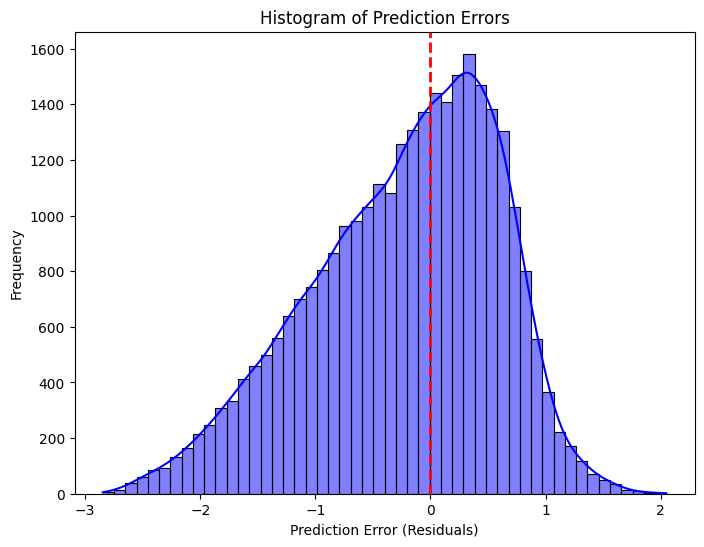

In [12]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns


model.eval()

all_predictions = []
all_targets = []


with torch.no_grad():
    for batch in val_loader:  
        X = batch["X_jet"].to(device) .float() 
        y = batch["m"].to(device).float()

        predictions = model(X).squeeze()  

        all_predictions.extend(predictions.cpu().numpy())  
        all_targets.extend(y.cpu().numpy())  


all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Compute residuals (errors)
errors = all_predictions - all_targets

# Plot histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=50, kde=True, color="blue")
plt.axvline(0, color='red', linestyle='dashed', linewidth=2)  # Zero error line
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.show()


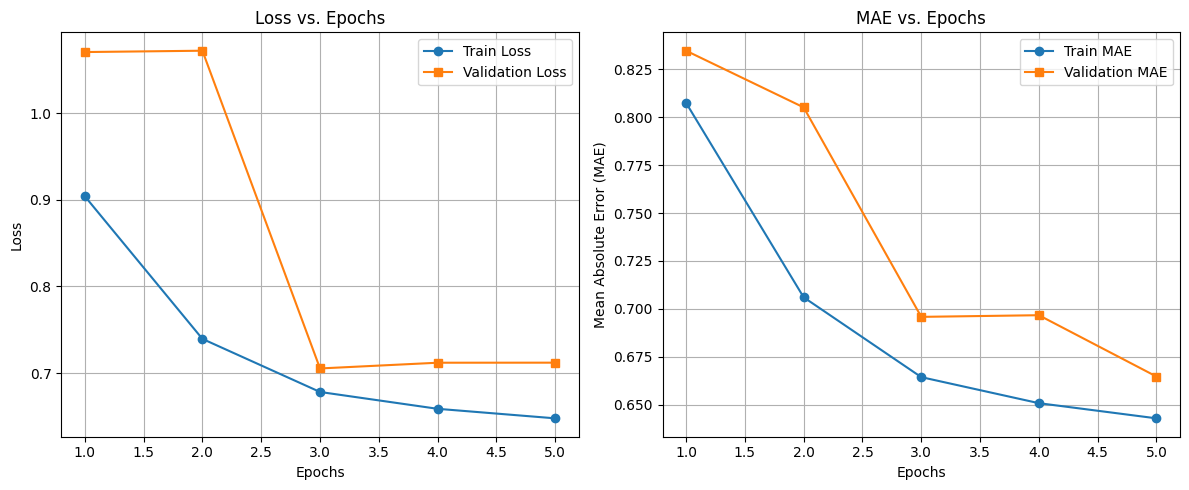

In [13]:
import matplotlib.pyplot as plt
import json

with open("training_metrics.json", "r") as f:
    metrics = json.load(f)

train_losses = metrics["train_loss"]
val_losses = metrics["val_loss"]
train_maes = metrics["train_mae"]
val_maes = metrics["val_mae"]

epochs = range(1, len(train_losses) + 1)

# Plot Loss Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epochs")
plt.legend()
plt.grid(True)

# Plot MAE Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, train_maes, label="Train MAE", marker="o")
plt.plot(epochs, val_maes, label="Validation MAE", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


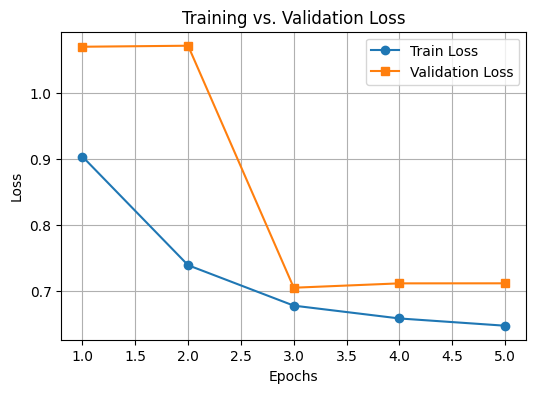

In [14]:
plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.show()
